In [3]:
from tensorflow.python.client import device_lib
import tensorflow as tf

print(tf.__version__)

device_lib.list_local_devices()

2.5.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 311141846393715253,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1748933019
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15458447450892845098
 physical_device_desc: "device: 0, name: GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [4]:
import glob
import os

from tqdm import tqdm
import pandas as pd
import numpy as np

import cv2

tqdm.pandas()

# ROOT = "/content/drive/MyDrive/research/data"
# pd.read_csv(os.path.join(ROOT, 'train_meta.csv'))

ROOT = "D:\\tmp"


def read_img(p):
    """
      read image and resize it to square shape (filling empty zeroes)
    """
    im = cv2.imread(p, 0)
    if (im is None):
        print(p)
        return

    h, w = im.shape
    s = max(h, w)

    im_new = np.zeros((s, s), np.uint8)
    x_center, y_center = (s - w)//2, (s - h) // 2

    im_new[y_center: (h + y_center), x_center: (w + x_center)] = im

    return im_new


# MASK DATA import
MASKED_DIR = "AFDB_face_dataset"

mask_sub = glob.glob(os.path.join(ROOT, MASKED_DIR, "*", "*"))

df_mask = pd.DataFrame(np.asarray(mask_sub), columns=['filename'])
# df_mask['label'] = df_mask.name.progress_apply(
#     os.path.dirname).progress_apply(os.path.basename)
# df_mask['image'] = df_mask.name.progress_apply(read_img)
df_mask['class'] = 'no_mask'

del mask_sub

# NON-MASK DATA import
NON_MASK_DIR = "AFDB_masked_face_dataset"

nmask_sub = glob.glob(os.path.join(ROOT, NON_MASK_DIR, "*", "*"))

df_nmask = pd.DataFrame(np.asarray(nmask_sub), columns=['filename'])
# df_nmask['label'] = df_nmask.name.progress_apply(
#     os.path.dirname).progress_apply(os.path.basename)
# df_nmask['image'] = df_nmask.name.progress_apply(read_img)
df_nmask['class'] = 'mask'

del nmask_sub

df = pd.concat([df_mask, df_nmask])

del df_mask
del df_nmask


df['class'] = df['class'].astype('category')
df


,filename,class
0,D:\tmp\AFDB_face_dataset\aidai\0_0_aidai_0014.jpg,no_mask
1,D:\tmp\AFDB_face_dataset\aidai\0_0_aidai_0029.jpg,no_mask
2,D:\tmp\AFDB_face_dataset\aidai\0_0_aidai_0043.jpg,no_mask
3,D:\tmp\AFDB_face_dataset\aidai\0_0_aidai_0074.jpg,no_mask
4,D:\tmp\AFDB_face_dataset\aidai\0_0_aidai_0080.jpg,no_mask
...,...,...
1394,D:\tmp\AFDB_masked_face_dataset\zhudan\1_0_13.jpg,mask
1395,D:\tmp\AFDB_masked_face_dataset\zhuowenxuan\0_...,mask
1396,D:\tmp\AFDB_masked_face_dataset\zhuyilong\0_0_...,mask
1397,D:\tmp\AFDB_masked_face_dataset\zhuyilong\0_0_...,mask


In [53]:
# t = df[df['class']=='no_mask'].iloc[np.random.randint(0, 400)]
# print(t)

# from keras.preprocessing import image

# im = image.load_img(t['filename'], target_size=(224, 224))
# im = image.img_to_array(im)
# im = np.expand_dims(im, axis=0)

# model.predict(preprocess_input(im))

filename    D:\tmp\AFDB_face_dataset\caiyilin\1_0_caiyilin...
class                                                 no_mask
Name: 164, dtype: object


array([[2.1599959e-17, 1.0000000e+00]], dtype=float32)

In [1]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.resnet50 import ResNet50

RESNET_WEIGHT_PATH = Path("D:\\tmp\\pretrained\\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Hyper-params
RESNET50_POOLING_AVERAGE = 'avg'

model = Sequential()
model.add(
    ResNet50(
        include_top=False,
        pooling=RESNET50_POOLING_AVERAGE,
        weights='imagenet')
)

model.add(Dense(2, activation='softmax'))
model.layers[0].trainable = False

# model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [2]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6,
                     momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])


In [5]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 224
BATCH_SIZE_TRAINING = 50
BATCH_SIZE_VALIDATION = 50

train, test = train_test_split(df, test_size=0.2)

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_dataframe(
    dataframe=train,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='categorical')

validation_generator = data_generator.flow_from_dataframe(
    dataframe=test,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical'
)

del train
del test
del df

(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))


Found 73493 validated image filenames belonging to 2 classes.
Found 18374 validated image filenames belonging to 2 classes.


(50, 1470, 50, 368)

In [6]:
from datetime import datetime

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

EARLY_STOP_PATIENCE = 3

cb_early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(
    filepath='..\\working\\best.hdf5',
    monitor='val_loss',
    save_best_only=True,
    mode='auto')

logs = "logs/" + datetime.now().strftime('%Y%m%d-%H%M%S')
tboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = logs,
    histogram_freq = 1,
    profile_batch = '1,5'
)
 
fit_hist = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks=[cb_checkpointer, cb_early_stopper, TqdmCallback(verbose=2), tboard_callback],
    verbose=1
)

# model.fit(train_generator)

model.load_weights("../working/best.hdf5")


0epoch [00:00, ?epoch/s]C:\Users\defaultuser0.LAPTOP-POTNR7PE\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10


In [4]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10796), started 0:25:34 ago. (Use '!kill 10796' to kill it.)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


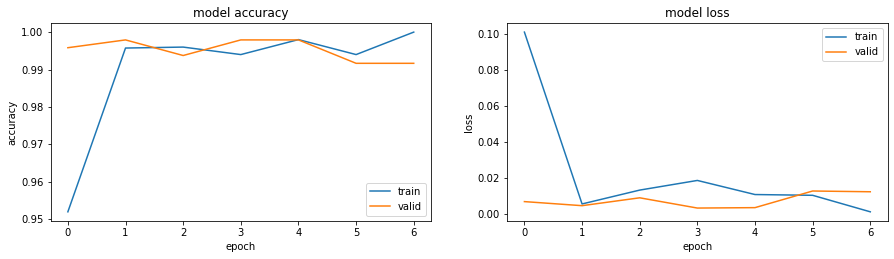

In [15]:
from matplotlib import pyplot as plt

print(fit_hist.history.keys())

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_hist.history['binary_accuracy'])  
plt.plot(fit_hist.history['val_binary_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_hist.history['loss'])  
plt.plot(fit_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:


model.predict()

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.get_visible_devices())

TensorFlow version: 2.5.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [81]:
tf.compat.v2.__internal__.distribute

<module 'tensorflow.compat.v2.__internal__.distribute' from 'C:\\Users\\defaultuser0.LAPTOP-POTNR7PE\\miniconda3\\envs\\tf-gpu\\lib\\site-packages\\tensorflow\\_api\\v2\\compat\\v2\\__internal__\\distribute\\__init__.py'>

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2916 - accuracy: 0.9155
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1450 - accuracy: 0.9562
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1103 - accuracy: 0.9670
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0891 - accuracy: 0.9723
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0737 - accuracy: 0.9768
